# Imports

In [1]:
import logging
import os
import warnings

from matplotlib import pyplot as plt
import matplotlib.animation as animation
import matplotlib.style as style

from IPython.display import HTML
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras import layers

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [2]:
print("TF version:", tf.__version__)


TF version: 2.5.1


# Generate random images

In [3]:
def generate_movies(n_samples=1200, n_frames=15):
    row = 80
    col = 80
    noisy_movies = np.zeros((n_samples, n_frames, row, col, 3), dtype=np.float)
    shifted_movies = np.zeros((n_samples, n_frames, row, col, 3), dtype=np.float)
    
    epsilon = np.random.random() /1000
    
    Y = np.zeros((n_samples, 4), dtype=np.float)
    
    for i in range(n_samples):
        # Add 3 to 7 moving squares
        n = np.random.randint(3, 8)
        
        # Direction of motion (All squares are moving in the same direction)
        directionx = np.random.choice([-1, 0, 1])
        directiony = np.random.choice([-1, 0, 1])
        
        # Make the target smooth
        # Section 7 of https://arxiv.org/pdf/1512.00567.pdf
        Y[i, ::] = epsilon
        if directionx < 0:
            Y[i, 0] = 1
        if directionx > 0:
            Y[i, 1] = 1
        if directiony < 0:
            Y[i, 2] = 1
        if directiony > 0:
            Y[i, 3] = 1
        Y[i] = Y[i] / np.linalg.norm(Y[i])
                
        for j in range(n):
            # Initial position
            xstart = np.random.randint(20, 60)
            ystart = np.random.randint(20, 60)
            
            directionx *= np.random.randint(1, 3)
            directiony *= np.random.randint(1, 3)

            # Size of the square
            w = np.random.randint(2, 4)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                noisy_movies[i, t, x_shift - w: x_shift + w, y_shift - w: y_shift + w, ::] += 1

                # Make it more robust by adding noise.
                # The idea is that if during inference,
                # the value of the pixel is not exactly one,
                # we need to train the network to be robust and still
                # consider it as a pixel belonging to a square.
                if np.random.randint(0, 2):
                    noise_f = (-1)**np.random.randint(0, 2)
                    noisy_movies[i, t, x_shift-w-1: x_shift+w+1, y_shift-w-1: y_shift+w+1, ::] += noise_f * 0.1

                # Shift the ground truth by 1
                x_shift = xstart + directionx * (t + 1)
                y_shift = ystart + directiony * (t + 1)
                shifted_movies[i, t, x_shift - w: x_shift + w, y_shift - w: y_shift + w, ::] += 1

    # Cut to a 40x40 window
    noisy_movies = noisy_movies[::, ::, 20:60, 20:60, ::]
    shifted_movies = shifted_movies[::, ::, 20:60, 20:60, ::]
    noisy_movies = np.clip(noisy_movies, 0., 1.) # noisy_movies[noisy_movies >= 1] = 255
    shifted_movies = np.clip(shifted_movies, 0., 1.)
    return noisy_movies, shifted_movies, np.array(Y)

In [4]:
noisy_movies, shifted_movies, Y = generate_movies(n_samples=1200)

In [5]:
print(noisy_movies.shape, Y.shape)

(1200, 15, 40, 40, 3) (1200, 4)


In [6]:
%matplotlib inline

def get_label(y):
    label = []

    if y[0] > 0.6:
      label.append('UP') 
    if y[1] > 0.6:
      label.append('DOWN')
    if y[2] > 0.6:
      label.append('LEFT')
    if y[3] > 0.6:
      label.append('RIGHT')

    if len(label) == 0:
        label.append('STILL')

    return' '.join(label)

def show_prediction(X, y, model, ax):
    
    X = np.expand_dims(X, axis=0)
        
    # Get movie info
    title = get_label(y)

    # Generate prediction
    prediction = model.predict(X)
    
    title += 'vs '+ get_label(prediction[0])

    # Dispaly image with prediction
    style.use('default')
    #plt.figure(figsize=(8,4))
    #plt.title(title, fontsize=9)
    
    frame = 0
    im = ax.imshow(movie[frame]);

    #ax.close() # this is required to not display the generated image

    def init():
        im.set_data(movie[0,:,:,:])

    def animate(i):
        im.set_data(movie[i,:,:,:])
        return im

    anim = animation.FuncAnimation(ax, animate, init_func=init, frames=movie.shape[0], interval=50);


In [7]:
def display(nrows, ncols, X, Y, model=None):

    plt.xkcd()

    # See https://matplotlib.org/stable/tutorials/introductory/customizing.html

    plt.rcParams['xtick.bottom'] = False
    plt.rcParams['ytick.left'] = False
    plt.rcParams['xtick.labelbottom'] = False
    plt.rcParams['ytick.labelleft'] = False

    #fig = plt.figure()
    #fig.suptitle(label)

    maxi = X.max()
    mini = X.min()
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols);
    
    axs = np.array(axs)
    
    movies = []

    if model != None:
        Y_hat = model.predict(X[::, ::, ::, ::, ::])
    
    for i, ax in enumerate(axs.reshape(-1)):
        im = ax.imshow(X[i, 0, ::, ::, ::]);
        label = get_label(Y[i])
        if model != None:
            label += ' vs ' + get_label(Y_hat[i]) + \
            "\n[{:.2f},{:.2f},{:.2f},{:.2f}]".format(Y_hat[i, 0], Y_hat[i, 1], Y_hat[i, 2], Y_hat[i, 3])
        ax.set_title(label, fontsize=9)
        movies.append(im)
                      
    def animate(frame):
        for i, ax in enumerate(axs.reshape(-1)):
            movies[i].set_data(X[i, frame, ::, ::, ::])
            
        return movies


    anim = animation.FuncAnimation(fig, animate, blit=True, frames=X.shape[1], repeat=True, interval=100)

    plt.tight_layout();

    return anim

# Create Model

In [8]:
seq_len = 15
img_height = 40
img_width = 40

classes = ['up', 'down', 'left', 'right']

model = tf.keras.Sequential()
model.add(layers.ConvLSTM2D(filters = 64, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = noisy_movies.shape[1:]))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(4, activation = "sigmoid"))

2021-09-15 15:28:25.933484: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 38, 38, 64)        154624    
_________________________________________________________________
dropout (Dropout)            (None, 38, 38, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 92416)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               23658752  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 23,814,404
Trainable params: 23,814,404
Non-trainable params: 0
____________________________________________

In [10]:
#from tensorflow.keras.utils import plot_model
#plot_model(model)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(noisy_movies, Y, test_size=0.20, shuffle=True, random_state=0)

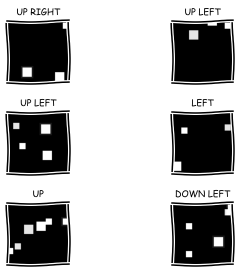

In [46]:
nrows = 3
ncols = 2

np.random.seed(42)
ind = np.random.randint(0, high=X_train.shape[0], size=nrows*ncols)

anim = display(nrows, ncols, X_train[ind, ::, ::, ::, ::], y_train[ind, ::], model=None)

In [47]:
HTML(anim.to_html5_video())

In [15]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost# Define 

In [16]:
@tf.function
def macro_f1(y, y_hat, thresh=0.6):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.001)
model.compile(loss=macro_soft_f1, optimizer=opt, metrics=[macro_f1])
 
earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
 
history = model.fit(x = X_train, y = y_train, epochs=40, batch_size = 8 , shuffle=True, validation_split=0.2, callbacks=callbacks)

Epoch 1/40
96/96 [==============================] - 155s 2s/step - loss: 0.4766 - macro_f1: 0.5432 - val_loss: 0.4460 - val_macro_f1: 0.5281
Epoch 2/40
96/96 [==============================] - 157s 2s/step - loss: 0.4484 - macro_f1: 0.5307 - val_loss: 0.4355 - val_macro_f1: 0.5018
Epoch 3/40
96/96 [==============================] - 170s 2s/step - loss: 0.4114 - macro_f1: 0.5088 - val_loss: 0.4021 - val_macro_f1: 0.5081
Epoch 4/40
96/96 [==============================] - 205s 2s/step - loss: 0.3873 - macro_f1: 0.5234 - val_loss: 0.4333 - val_macro_f1: 0.5041
Epoch 5/40
96/96 [==============================] - 206s 2s/step - loss: 0.4148 - macro_f1: 0.5359 - val_loss: 0.3775 - val_macro_f1: 0.5286
Epoch 6/40
96/96 [==============================] - 200s 2s/step - loss: 0.3561 - macro_f1: 0.5210 - val_loss: 0.4467 - val_macro_f1: 0.4595
Epoch 7/40
96/96 [==============================] - 195s 2s/step - loss: 0.3548 - macro_f1: 0.5041 - val_loss: 0.3821 - val_macro_f1: 0.5147
Epoch 8/40
96

In [18]:
def learning_curves(history):
    """Plot the learning curves of loss and macro f1 score 
    for the training and validation datasets.
    
    Args:
        history: history callback of fitting a tensorflow keras model 
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    macro_f1 = history.history['macro_f1']
    val_macro_f1 = history.history['val_macro_f1']
    
    epochs = len(loss)

    style.use("bmh")
    plt.figure(figsize=(8, 8))
    
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    plt.rcParams['xtick.labelbottom'] = True
    plt.rcParams['ytick.labelleft'] = True

    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs+1), macro_f1, label='Training Macro F1-score')
    plt.plot(range(1, epochs+1), val_macro_f1, label='Validation Macro F1-score')
    plt.legend(loc='lower right')
    plt.ylabel('Macro F1-score')
    plt.title('Training and Validation Macro F1-score')
    plt.xlabel('epoch')

    plt.show()
    
    return loss, val_loss, macro_f1, val_macro_f1

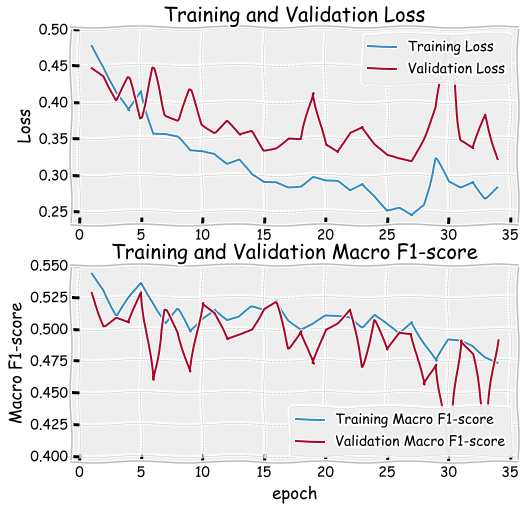

([0.4765688478946686,
  0.448417067527771,
  0.41140297055244446,
  0.3873284161090851,
  0.41484498977661133,
  0.3560818135738373,
  0.35481855273246765,
  0.3508481979370117,
  0.3328166604042053,
  0.3329020142555237,
  0.3297843039035797,
  0.31576594710350037,
  0.3203698396682739,
  0.29935720562934875,
  0.2895011901855469,
  0.2901923358440399,
  0.2839067280292511,
  0.28460440039634705,
  0.2966558039188385,
  0.2908089756965637,
  0.2902697026729584,
  0.27839890122413635,
  0.2881687581539154,
  0.2720247209072113,
  0.2506827414035797,
  0.25359630584716797,
  0.24324488639831543,
  0.2590521275997162,
  0.32240429520606995,
  0.2901381850242615,
  0.28240057826042175,
  0.2910415530204773,
  0.2676432132720947,
  0.2821721136569977],
 [0.446045845746994,
  0.43551698327064514,
  0.40208831429481506,
  0.4333232641220093,
  0.37749600410461426,
  0.4467378854751587,
  0.38205936551094055,
  0.3747599124908447,
  0.4166247844696045,
  0.36901572346687317,
  0.3580314218997

In [19]:
learning_curves(history)

# See predictions

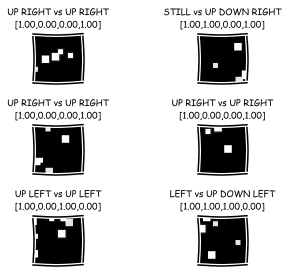

In [44]:
nrows = 3
ncols = 2

ind = np.random.randint(0, high=X_test.shape[0], size=nrows*ncols)

anim_test = display(nrows, ncols, X_test[ind, ::, ::, ::, ::], y_test[ind, ::], model=model)

In [45]:
HTML(anim_test.to_html5_video())